## Tensor Networks - Non - Interview option

### Defining all the necessary functions

In [1]:
using LinearAlgebra, TensorOperations, Plots

In [2]:
struct myMPS{T<:Number}
    """
    This creates a parameterized type myMPS where:

    - T must be a subtype of Number (like Float64, Complex, etc.)
    - TensorList is a 1D array containing 3D arrays of type T
    - Each 3D tensor represents (left bond, system spin, right bond) indices
    """
    TensorList::Array{Array{T,3},1} #List of myMPS tensors
    #Tensor indices - left bond, system spin, right bond
end

""" The following helper functions extends some base functions to act on our struct type """
Base.length(M::myMPS) = length(M.TensorList)  #number of sites
phys_dim(M::myMPS) = size(M.TensorList[1],2)  #physical dimension
max_bond_dim(M::myMPS) = findmax([size(ten,1) for ten in M.TensorList])[1] #bond dimension
Base.copy(M::myMPS) = myMPS(copy(M.TensorList)) #copy an MPS
     

In [3]:
# Create a simple MPS with 2 sites
tensor1 = zeros(Float64, 2,2,2)  # 2×2×2 tensor
tensor2 = zeros(Float64, 2,2,2)  # 2×2×2 tensor
mps = myMPS([tensor1, tensor2])

println(length(mps))        # 2 (sites)
println(phys_dim(mps))      # 2 (physical dimension)
println(max_bond_dim(mps))  # 2 (maximum bond dimension)
     

2
2
2


In [4]:
function randMPS(T::Type,N,d,D)
    ## generate a random MPS with size N, physical dimension d and bond dimension D
    ## The MPS is in left canonical form
    Ts = Array{T,3}[]
    dL = 1;
    dR = 1;
    for n in 1:N
        dL = dR  ## left bond dimension
        dR = min(D,dL*d,d^n,d^(N-n)) ## right bond dimension
        X = randn(dL*d,dR)
        A = reshape(X,(dL,d,dR))
        push!(Ts,A)
    end
    M = myMPS(Ts)
end

randMPS (generic function with 1 method)

In [5]:
function truncate(S::Vector{<:Real}, max_bd::Int, max_err::Float64)
    ## Given an array S (descending), determine the truncation
    ## based on which of max bond dimesion or max err is reached
    err = 0.0
    set_bd = max_bd
    for i in length(S):-1:1
        err = err + S[i]^2
        if(err>max_err)
            if(i<max_bd)
                set_bd = i
            end
            break
        end
    end
    return set_bd
end

truncate (generic function with 1 method)

In [6]:
function canonicalize_left_one_site(M::myMPS, site::Int;truncation = false, max_bd = 1024, max_err = 1E-10)
    ## A1 := M[site], A2 := M[site+1]
    ## A1 = USV' => A1=U, A2 = SVt (update)
    ## Truncate S if truncation = true
    ## return S and the updated myMPS M
    A1 = M.TensorList[site]
    DL,d,DR = size(A1)
    A1_mat = reshape(A1, (DL*d,DR))
    U = nothing; S =nothing; V =nothing;
    try
        U,S,V = svd(A1_mat,alg=LinearAlgebra.DivideAndConquer())
    catch
        U,S,V = svd(A1_mat,alg=LinearAlgebra.QRIteration())
    end
    if(norm(S)<eps(Float64))
         throw("zero norm")
    end
    S = S./norm(S)
    if(truncation == true)
        set_bd = truncate(S,max_bd,max_err)
        trunc_err = norm(S[set_bd+1:end])^2
        if(trunc_err>1E-6)
            println("truncation error:",trunc_err)
        end
        S = S[1:set_bd]
        U = U[:,1:set_bd]
        V = V[:,1:set_bd]
    end
    M.TensorList[site] = reshape(U, (DL,d,length(S)))
    if(site<length(M))
        SVt = diagm(0=>S)*V'
        M.TensorList[site+1] = ncon([SVt, M.TensorList[site+1]],[[-1,1],[1,-2,-3]])
    end
    return S, M
end

function canonicalize_right_one_site(M::myMPS, site::Int;truncation = false, max_bd = 1024, max_err = 1E-10)
    ## A1 := M[site], A2 :=M[site-1]
    ## A1 = USV' => A1=V', A2 = US
    ## Truncate S if truncation = true
    A1 = M.TensorList[site]
    DL,d,DR = size(A1)
    A1_mat = reshape(A1, (DL,DR*d))
    U = nothing; S=nothing; V=nothing;
    try
        U,S,V = svd(A1_mat,alg=LinearAlgebra.DivideAndConquer())
    catch
        U,S,V = svd(A1_mat,alg=LinearAlgebra.QRIteration())
    end
    if(norm(S)<eps(Float64))
         throw("zero norm")
    end
    S = S./norm(S)
    if(truncation == true)
        set_bd = truncate(S,max_bd,max_err)
        trunc_err = norm(S[set_bd+1:end])^2
        if(trunc_err>1E-6)
            println("truncation error:",trunc_err)
        end
        S = S[1:set_bd]
        U = U[:,1:set_bd]
        V = V[:,1:set_bd]
    end
    M.TensorList[site] = reshape(V, (length(S),d,DR))
    if(site>1)
        US = U*diagm(0=>S)
        M.TensorList[site-1] = ncon([US, M.TensorList[site-1]],[[1,-3],[-1,-2,1]])
    end
    return S, M
end

function canonicalize_left(M::myMPS;truncation = false, max_bd = 1024, max_err = 1E-10)
    ## Return a left canonical form of the state (normalized automatically)
    N = length(M)
    for i in 1:N
        ~, M = canonicalize_left_one_site(M, i, truncation=truncation,max_bd=max_bd,max_err=max_err)
    end
    return M
end

function canonicalize_right(M::myMPS;truncation = false, max_bd = 1024, max_err = 1E-10)
    ## Return a right canonical form of the state (normalized automatically)
    N = length(M)
    for i in N:-1:1
        ~, M = canonicalize_right_one_site(M, i, truncation=truncation,max_bd=max_bd,max_err=max_err)
    end
    return M
end


canonicalize_right (generic function with 1 method)

In [7]:
function product_state_init(T::Type, d::Int, N::Int) 
    ## Initialize a product state |0101010101...>
    ## T - data type
    ## d - local dimension
    ## N - number of sites
    Ten = zeros(T,1,d,1)
    Ten[1,1,1] = 1.0
    myMPSTensors = Array{T,3}[]
    for i in 1:N
        push!(myMPSTensors, Ten)
    end
    return myMPS(myMPSTensors)
end
     


product_state_init (generic function with 1 method)

In [8]:
function evolution_two_site(M::myMPS, U::Matrix, site::Int, dir = "l"; truncation = false, max_bd = 1024, max_err=1E-10)
    ## Evolve the pure state by U 
    ## Assuming U is two-site
    ## further assuming the two sites are the center of canonical form if truncation = true (important!)
    ## site is the first site # of the unitary (1 to N-1)
    ## the [site] of the two sites is put into left canonical form (if dir = "l")
    ## the [site+1] of the two sites is put into right canonical form (if dir = "r")
    ## return S and M (automatically normalize the state)
    myMPSTensors = M.TensorList
    @assert site<length(M)
    A1 = myMPSTensors[site]
    A2 = myMPSTensors[site+1]
    d1 = size(A1,2)
    d2 = size(A2,2)
    DL = size(A1,1)
    DR = size(A2,3)
    U = reshape(U,(d1,d2,d1,d2)) # site 1 ket, site 2 ket, site 1 bra, site 2 bra
    A_evol = ncon([A1,A2,U],[[-1,1,2],[2,3,-4],[1,3,-2,-3]])
    A_evol_mat = reshape(A_evol,(DL*d1,DR*d2))
    U2 = nothing; S2=nothing; V2=nothing;
    try
        U2,S2,V2 = svd(A_evol_mat,alg=LinearAlgebra.DivideAndConquer())
    catch
        U2,S2,V2 = svd(A_evol_mat,alg=LinearAlgebra.QRIteration())
    end
    S2 = S2./norm(S2)
    if(truncation == true)
        set_bd = truncate(S2, max_bd, max_err)
        trunc_err = norm(S2[set_bd+1:end])^2
        if(trunc_err>1E-6)
            println("truncation error:",trunc_err)
        end
        S2 = S2[1:set_bd]
        U2 = U2[:,1:set_bd]
        V2 = V2[:,1:set_bd]
    end
    if(dir == "l")
        AL = reshape(U2, (DL,d1,length(S2)))
        AR = reshape(diagm(0=>S2)*V2',(length(S2),d2,DR))
    else
        AL = reshape(U2*diagm(0=>S2), (DL,d1,length(S2)))
        AR = reshape(V2',(length(S2),d2,DR))
    end
    M.TensorList[site] = AL
    M.TensorList[site+1] = AR    
    return S2, M
end

evolution_two_site (generic function with 2 methods)

In [9]:
function TEBD_layer(M::myMPS, U::Matrix, eo = "o";truncation = false, max_bd = 1024, max_err = 1E-10)
    ## Apply TEBD layer at each even/odd sites
    ## Note - right canonical form assumed in beginning, and left canonical form in the end
    N = length(M)
    d = phys_dim(M)
    if(eo == "o")
        site0 = 1
    else
        S, M = canonicalize_left_one_site(M,1,truncation = truncation, max_bd = max_bd, max_err = max_err)
        site0 = 2
    end
    for site in site0:2:N-1
        S, M = evolution_two_site(M, U, site, "l", truncation = truncation, max_bd = max_bd, max_err = max_err)
        S, M = canonicalize_left_one_site(M,site+1,truncation = truncation, max_bd = max_bd, max_err = max_err)
    end
    return M
end
     


TEBD_layer (generic function with 2 methods)

### Modified TEBD_Ising to output Energy

In [10]:
function TEBD_Ising(M0::myMPS,g::Float64,dt::Float64, chimax::Int = 128,err::Float64 = 1E-10, etol = 1E-10, Tmax = 10.0)
    ## Time evolution exp(-TH)|M0> until T=Tmax or energy converges to precision etol
    ## H = - XX - gZ (boundary field cut half)
    ## using second order trotter with time step dt
    ## truncation according to error <= err or bond dimesion reaches chimax
    sigmaX = [[0.0 1.0];[1.0 0.0]]
    sigmaZ = [[1.0 0.0];[0.0 -1.0]]
    Id = [[1.0 0.0];[0.0 1.0]]
    @tensor h12[a,b,c,d] := -sigmaX[a,c]*sigmaX[b,d]-g*sigmaZ[a,c]*Id[b,d]/2-g*Id[a,c]*sigmaZ[b,d]/2
    h12_mat = reshape(h12,(4,4))
    U_half = exp(-dt*h12_mat/2) ##matrix exponential
    U = U_half*U_half 
    
    maxstep = convert(Int,round(Tmax/dt))
    L = length(M0)
    ## compute initial energy
    M = canonicalize_left(M0)
    Ein = 0.0;
    for i in L:-1:2
        AR = M.TensorList[i]
        AL = M.TensorList[i-1]
        Ei = ncon([h12,AL,conj(AL),AR,conj(AR)],[[2,5,3,7],[1,2,4],[1,3,6],[4,5,8],[6,7,8]])
        Ein = Ein+real(Ei[1])
        ~,M = canonicalize_right_one_site(M,i)
    end
    Eout=Ein
    println("Starting TEBD for Ising model, g=$g, L=$L, chimax=$chimax, dt=$dt")
    for step in 1:maxstep
        #println("Step $step")
        M = TEBD_layer(M,U_half,"o",truncation = true, max_bd = chimax, max_err = err)
        M = canonicalize_right(M)
        M = TEBD_layer(M,U,"e",truncation = true, max_bd = chimax, max_err = err)
        M = canonicalize_right(M)
        M = TEBD_layer(M,U_half,"o",truncation = true, max_bd = chimax, max_err = err)
        Eout = 0.0;
        for i in L:-1:2
            AR = M.TensorList[i]
            AL = M.TensorList[i-1]
            Ei = ncon([h12,AL,conj(AL),AR,conj(AR)],[[2,5,3,7],[1,2,4],[1,3,6],[4,5,8],[6,7,8]])
            Eout = Eout+real(Ei[1])
            ~,M = canonicalize_right_one_site(M,i)
        end
        bd = max_bond_dim(M)
        #println("Maximal bond dimension: $bd")
        if(Ein-Eout<etol)
            println("STOP due to energy convergence")
            break
        else
            dE = Eout-Ein
            #println("Energy = $Eout, energy change = $dE")
            Ein = Eout
        end
        if(step == maxstep)
            println("STOP due to time limit. Final energy:$Eout")
        end
    end
    return M,Eout
end

TEBD_Ising (generic function with 5 methods)

In [11]:
function TEBD_Ising1(M0::myMPS,g::Float64,dt::Float64, chimax::Int = 128,err::Float64 = 1E-10, etol = 1E-10, Tmax = 10.0)
    ## Time evolution exp(-TH)|M0> until T=Tmax or energy converges to precision etol
    ## H = - XX - gZ (boundary field cut half)
    ## using second order trotter with time step dt
    ## truncation according to error <= err or bond dimesion reaches chimax
    sigmaX = [[0.0 1.0];[1.0 0.0]]
    sigmaZ = [[1.0 0.0];[0.0 -1.0]]
    Id = [[1.0 0.0];[0.0 1.0]]
    @tensor h12[a,b,c,d] := -sigmaX[a,c]*sigmaX[b,d]-g*sigmaZ[a,c]*Id[b,d]/2-g*Id[a,c]*sigmaZ[b,d]/2
    h12_mat = reshape(h12,(4,4))
    U_half = exp(-dt*h12_mat/2) ##matrix exponential
    U = U_half*U_half 
    
    maxstep = convert(Int,round(Tmax/dt))
    L = length(M0)
    ## compute initial energy
    M = canonicalize_left(M0)
    Ein = 0.0;
    for i in L:-1:2
        AR = M.TensorList[i]
        AL = M.TensorList[i-1]
        Ei = ncon([h12,AL,conj(AL),AR,conj(AR)],[[2,5,3,7],[1,2,4],[1,3,6],[4,5,8],[6,7,8]])
        Ein = Ein+real(Ei[1])
        ~,M = canonicalize_right_one_site(M,i)
    end
    Eout=Ein
    E_list = [Eout]
    println("Starting TEBD for Ising model, g=$g, L=$L, chimax=$chimax, dt=$dt")
    for step in 1:maxstep
        #println("Step $step")
        M = TEBD_layer(M,U_half,"o",truncation = true, max_bd = chimax, max_err = err)
        M = canonicalize_right(M)
        M = TEBD_layer(M,U,"e",truncation = true, max_bd = chimax, max_err = err)
        M = canonicalize_right(M)
        M = TEBD_layer(M,U_half,"o",truncation = true, max_bd = chimax, max_err = err)
        Eout = 0.0;
        for i in L:-1:2
            AR = M.TensorList[i]
            AL = M.TensorList[i-1]
            Ei = ncon([h12,AL,conj(AL),AR,conj(AR)],[[2,5,3,7],[1,2,4],[1,3,6],[4,5,8],[6,7,8]])
            Eout = Eout+real(Ei[1])
            ~,M = canonicalize_right_one_site(M,i)
        end
        push!(E_list, Eout)
        bd = max_bond_dim(M)
        #println("Maximal bond dimension: $bd")
        if(abs(Ein-Eout)<etol)
            println("STOP due to energy convergence")
            break
        else
            dE = Eout-Ein
            #println("Energy = $Eout, energy change = $dE")
            Ein = Eout
        end
        if(step == maxstep)
            println("STOP due to time limit. Final energy:$Eout")
        end
    end
    return M,Eout,E_list
end

TEBD_Ising1 (generic function with 5 methods)

In [14]:
N = 10  
g = 0.5
dt = 0.01  
Tmax = 10.0  
chimax = 128  
err = 1E-10
etol = 1E-5

M0 = randMPS(Float64, N, 2, 4)  # Random initial MPS
M, ground_state_energy, E_list = TEBD_Ising1(M0, g, dt, chimax, err, etol, Tmax)

println("Final Ground State Energy:",ground_state_energy)


Starting TEBD for Ising model, g=0.5, L=10, chimax=128, dt=0.01
STOP due to time limit. Final energy:-0.9007621068111689
Final Ground State Energy:-0.9007621068111689


In [15]:
E_list

1001-element Vector{Float64}:
 -0.6663368845810151
 -1.9428978465021358
  0.047620551167820935
 -1.044306767527919
 -1.2005196752595455
 -2.064686481941881
 -1.585705560657438
 -1.9253835339851937
 -2.0161332040787636
 -2.2302271791283017
 -1.58374807084288
 -1.433480370584004
 -1.4059347497117614
  ⋮
 -1.144144483375182
 -2.2420461372792904
 -1.2024710742671916
 -2.0837646942667982
  7.125859600498607e-5
 -0.44367021757948133
 -1.570565449243258
 -1.6757957023987193
 -1.7476996464782144
 -1.7507468379733733
 -0.7957720729336091
 -0.9007621068111689

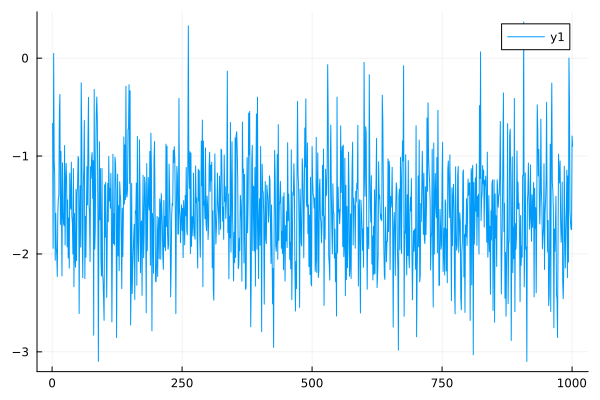

In [16]:
plot(E_list)

In [75]:
L = 20  
etol_values = [1E-6, 1E-8, 1E-10, 1E-12,1E-14,1E-16]  # Different error tolerances
energies = []

for etol in etol_values
    M0 = randMPS(Float64, L, 2, 4)  # Random initial MPS
    M, E_L = TEBD_Ising(M0, g, dt,chimax, err, etol, Tmax)
    push!(energies, E_L)
    println("etol = $etol, E($g, $L) = $E_L")
end


Starting TEBD for Ising model, g=0.5, L=20, chimax=128, dt=0.01
STOP due to energy convergence
etol = 1.0e-6, E(0.5, 20) = -1.5439335333310906
Starting TEBD for Ising model, g=0.5, L=20, chimax=128, dt=0.01
STOP due to energy convergence
etol = 1.0e-8, E(0.5, 20) = -1.0280615738699028
Starting TEBD for Ising model, g=0.5, L=20, chimax=128, dt=0.01
STOP due to energy convergence
etol = 1.0e-10, E(0.5, 20) = -1.3993417886336308
Starting TEBD for Ising model, g=0.5, L=20, chimax=128, dt=0.01
STOP due to energy convergence
etol = 1.0e-12, E(0.5, 20) = -1.75203250091787
Starting TEBD for Ising model, g=0.5, L=20, chimax=128, dt=0.01
STOP due to energy convergence
etol = 1.0e-14, E(0.5, 20) = -2.2313553302568687
Starting TEBD for Ising model, g=0.5, L=20, chimax=128, dt=0.01
STOP due to energy convergence
etol = 1.0e-16, E(0.5, 20) = -1.3294052918147954


In [76]:
energies

6-element Vector{Any}:
 -1.5439335333310906
 -1.0280615738699028
 -1.3993417886336308
 -1.75203250091787
 -2.2313553302568687
 -1.3294052918147954

In [77]:
fig = Figure()
ax1 = Axis(fig[1, 1], title = "Energy vs Etol", xlabel = "ETol", ylabel = "Energy",xscale=log10)
line1 = scatter!(ax1, etol_values, energies, color = :blue)
display(fig)


WGLMakie.Screen(
    framerate = 30.0,
    resize_to = nothing,
    px_per_unit = automatic,
    scalefactor = automatic,
    session = false,
    three = Channel{Any}(1) (empty),
    scene = Scene (600px, 450px):
  0 Plots
  1 Child Scene:
    └ Scene (600px, 450px),
)

In [69]:
L_values =[10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
g = 0.5
dt = 0.01  
Tmax = 10.0  
chimax = 128  
err = 1E-10
etol = 1E-12
energies2=[]
for L in L_values
    M0 = randMPS(Float64, L, 2, 4)  # Random initial MPS
    M, E_L = TEBD_Ising(M0, g, dt,chimax, err, etol, Tmax)
    push!(energies2, E_L)
    println("Length = $L, E($g, $L) = $E_L")
end

Starting TEBD for Ising model, g=0.5, L=10, chimax=128, dt=0.01
STOP due to energy convergence
Length = 10, E(0.5, 10) = -0.204989128951702
Starting TEBD for Ising model, g=0.5, L=12, chimax=128, dt=0.01
STOP due to energy convergence
Length = 12, E(0.5, 12) = -0.9004009500043492
Starting TEBD for Ising model, g=0.5, L=14, chimax=128, dt=0.01
STOP due to energy convergence
Length = 14, E(0.5, 14) = -0.011150244602672447
Starting TEBD for Ising model, g=0.5, L=16, chimax=128, dt=0.01
STOP due to energy convergence
Length = 16, E(0.5, 16) = -1.2069491039826752
Starting TEBD for Ising model, g=0.5, L=18, chimax=128, dt=0.01
STOP due to energy convergence
Length = 18, E(0.5, 18) = -1.9264984136715542
Starting TEBD for Ising model, g=0.5, L=20, chimax=128, dt=0.01
STOP due to energy convergence
Length = 20, E(0.5, 20) = -0.9225769000591509
Starting TEBD for Ising model, g=0.5, L=22, chimax=128, dt=0.01
STOP due to energy convergence
Length = 22, E(0.5, 22) = -2.1511872668306835
Starting TEB

In [70]:
energies2

16-element Vector{Any}:
 -0.204989128951702
 -0.9004009500043492
 -0.011150244602672447
 -1.2069491039826752
 -1.9264984136715542
 -0.9225769000591509
 -2.1511872668306835
 -4.209205070058966
 -1.573712301111603
 -2.3472139904624774
 -4.09213258637851
 -3.6173553639618268
 -1.7369584501695965
 -3.0554518871116167
 -3.373480164509231
 -5.312585829001842

In [74]:
fig = Figure()

# Plot the first dataset (sin(x))
ax1 = Axis(fig[1, 1], title = "Energy vs Lvalues", xlabel = "ETol", ylabel = "Energy")
line1 = scatter!(ax1, L_values, energies2, color = :blue, label = "sin(x)")
display(fig)


WGLMakie.Screen(
    framerate = 30.0,
    resize_to = nothing,
    px_per_unit = automatic,
    scalefactor = automatic,
    session = false,
    three = Channel{Any}(1) (empty),
    scene = Scene (600px, 450px):
  0 Plots
  1 Child Scene:
    └ Scene (600px, 450px),
)